In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [7]:
# Import the data
train=pd.read_csv("../input/spaceship-titanic/train.csv")
test=pd.read_csv("../input/spaceship-titanic/test.csv")

# Check
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [8]:
# Import
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Additional
import operator as op

### Training Set Check

In [9]:
# Null check
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [10]:
# Duplicate check
train.duplicated().sum()

0

In [11]:
# Unique values
for col in train.columns:
    print(f"{col}: {train[col].nunique()}")

PassengerId: 8693
HomePlanet: 3
CryoSleep: 2
Cabin: 6560
Destination: 3
Age: 80
VIP: 2
RoomService: 1273
FoodCourt: 1507
ShoppingMall: 1115
Spa: 1327
VRDeck: 1306
Name: 8473
Transported: 2


In [12]:
# Drop name
train.drop(['Name'], axis=1, inplace=True)

# Check
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [13]:
# Label encoder
labels = LabelEncoder()

# Fit and transform
train.Transported = labels.fit_transform(train.Transported)

# Check
train.Transported [0:15]

0     0
1     1
2     0
3     0
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    0
14    1
Name: Transported, dtype: int64

In [14]:
# Target variable
y = train.Transported

### Testing Set Check

In [15]:
# Null check
test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [16]:
# Duplicate check
test.duplicated().sum()

0

In [17]:
# Unique values
for col in test.columns:
    print(f"{col}: {test[col].nunique()}")

PassengerId: 4277
HomePlanet: 3
CryoSleep: 2
Cabin: 3265
Destination: 3
Age: 79
VIP: 2
RoomService: 842
FoodCourt: 902
ShoppingMall: 715
Spa: 833
VRDeck: 796
Name: 4176


In [18]:
# Drop name
test.drop(['Name'], axis=1, inplace=True)

# Check
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0


In [19]:
# Grab PassengerId for results submission
test_passenger_id = test.PassengerId

# Categorical Variable Investigation

For categorical variables, any missing values can be replaced by the most frequently occurring value.

In [20]:
# List of categorical variables 
cat_vars=['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']

In [21]:
# Fill null values
for cat in cat_vars:
    train[cat].fillna(train[cat].mode()[0], inplace=True)
    test[cat].fillna(test[cat].mode()[0], inplace=True)
    # Check null count
    print(f"Training set {cat} null count: {train[cat].isnull().sum()}")
    print(f"Testing set {cat} null count: {train[cat].isnull().sum()}\n\n")

Training set HomePlanet null count: 0
Testing set HomePlanet null count: 0


Training set CryoSleep null count: 0
Testing set CryoSleep null count: 0


Training set Cabin null count: 0
Testing set Cabin null count: 0


Training set Destination null count: 0
Testing set Destination null count: 0


Training set VIP null count: 0
Testing set VIP null count: 0




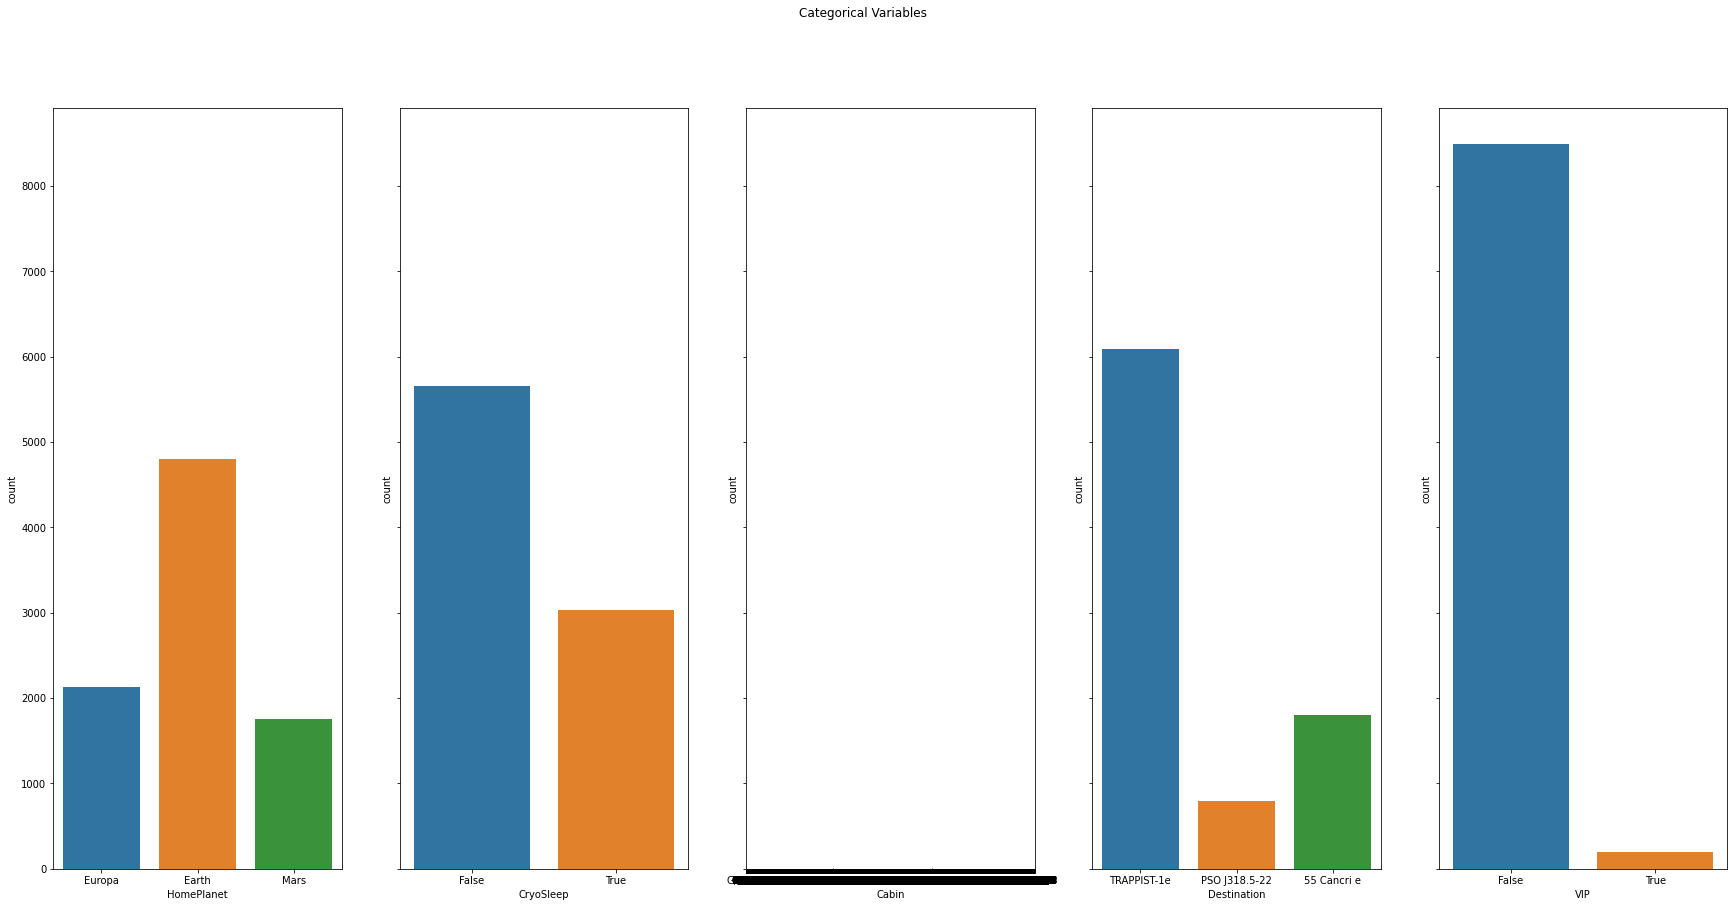

In [22]:
# Visualization - Training set only
fig, (ax0, ax1, ax2, ax3, ax4)=plt.subplots(1, 5, sharey=True, figsize=(30, 14))

# Title
fig.suptitle('Categorical Variables')

# Charts
ax0=sns.countplot(x='HomePlanet', data=train, ax=ax0)
ax1=sns.countplot(x='CryoSleep', data=train, ax=ax1)
ax2=sns.countplot(x='Cabin', data=train, ax=ax2)
ax3=sns.countplot(x='Destination', data=train, ax=ax3)
ax4=sns.countplot(x='VIP', data=train, ax=ax4)

# Show
plt.show()

Cabin will need to be broken out during feature engineering.

# Continuous Variable Investigation

In [23]:
# List of continuous variables
continuous_vars=['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

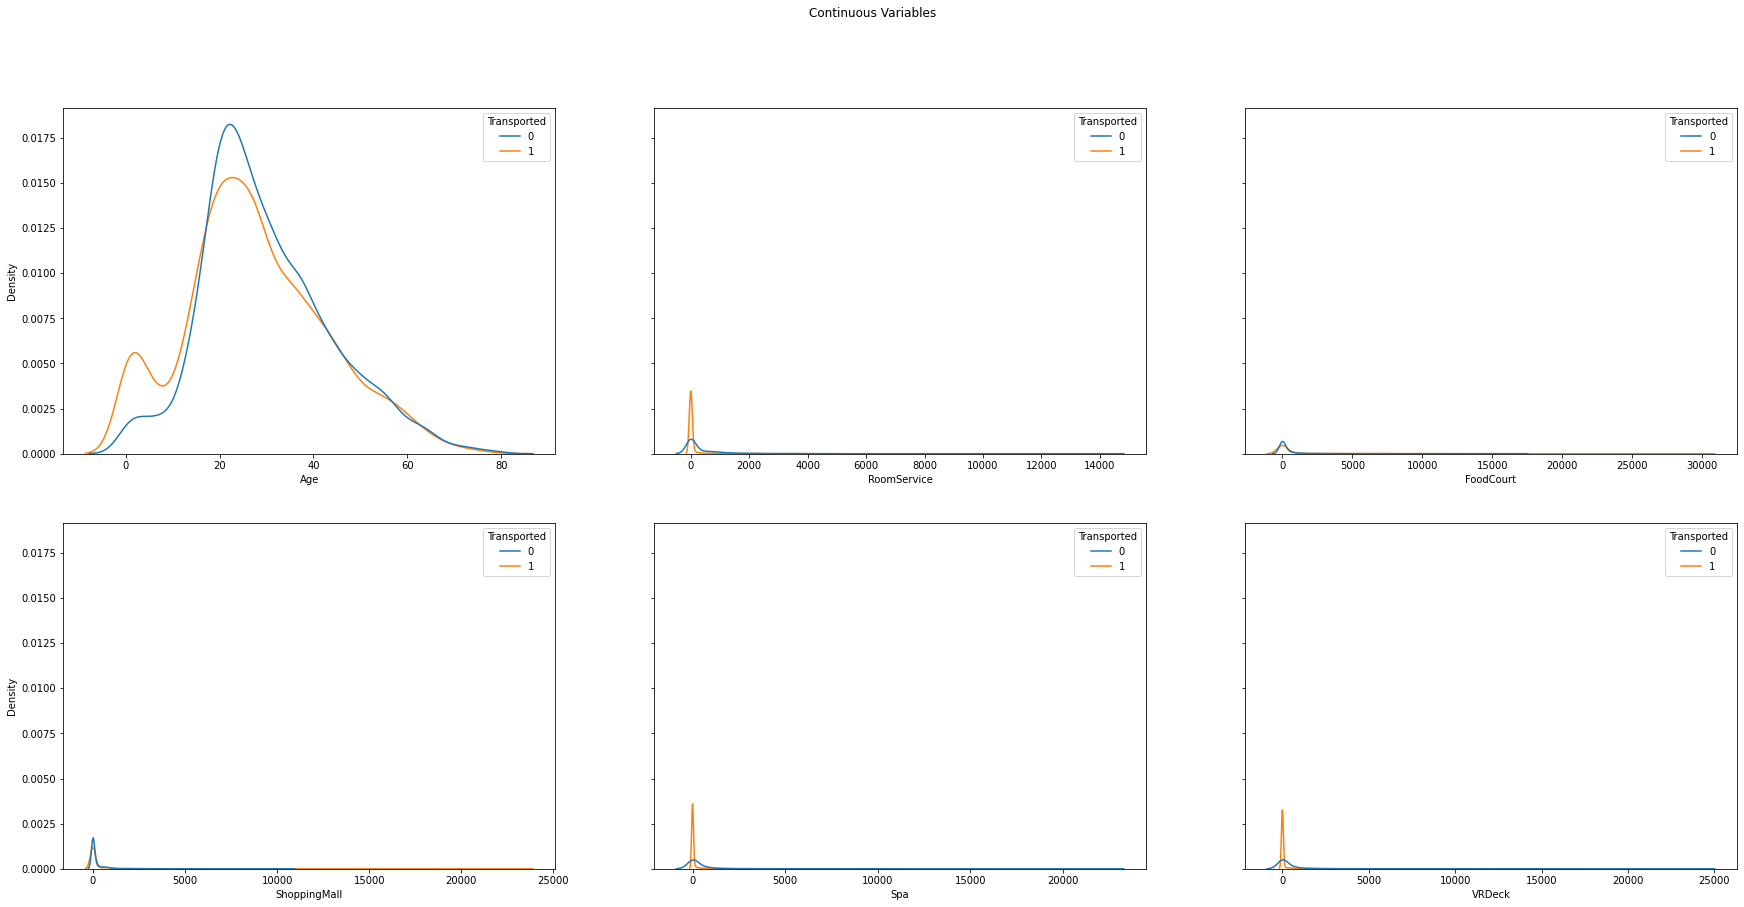

In [27]:
# Visualization - Training set only
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5))=plt.subplots(2, 3, sharey=True, figsize=(30, 14))

# Title
fig.suptitle('Continuous Variables')

# Charts
ax0=sns.kdeplot(x='Age', data=train, hue='Transported', ax=ax0)
ax1=sns.kdeplot(x='RoomService', data=train, hue='Transported', ax=ax1)
ax2=sns.kdeplot(x='FoodCourt', data=train, hue='Transported', ax=ax2)
ax3=sns.kdeplot(x='ShoppingMall', data=train, hue='Transported', ax=ax3)
ax4=sns.kdeplot(x='Spa', data=train, hue='Transported', ax=ax4)
ax5=sns.kdeplot(x='VRDeck', data=train, hue='Transported',ax=ax5)

# Show
plt.show()

The pronounced positive skew for RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck indicate it would benefit from a log(x+1) transformation. Age can likely be left alone given that the skew isn't that bad, and that by the sheer number of observations the traditional measures of central tendency are likely safe. For these reasons, null values should be handled in the following way:
- Age: Use the mean
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: Median

In [24]:
# Fill null values
for c in continuous_vars:
    if train[c].name == 'Age':
        train[c].fillna(train[c].mean(), inplace=True)
        test[c].fillna(test[c].mean(), inplace=True)
    else:
        train[c].fillna(train[c].median(), inplace=True)
        test[c].fillna(test[c].median(), inplace=True)
    # Check null count
    print(f"Training set {c} null count: {train[c].isnull().sum()}")
    print(f"Testing set {c} null count: {train[c].isnull().sum()}\n\n")

Training set Age null count: 0
Testing set Age null count: 0


Training set RoomService null count: 0
Testing set RoomService null count: 0


Training set FoodCourt null count: 0
Testing set FoodCourt null count: 0


Training set ShoppingMall null count: 0
Testing set ShoppingMall null count: 0


Training set Spa null count: 0
Testing set Spa null count: 0


Training set VRDeck null count: 0
Testing set VRDeck null count: 0




# Feature Engineering

## PassengerId
PassengerId needs to be split into two parts: group and passenger number. These can be used to obtain a traveling companion count variable.

In [25]:
# Split PassengerId into its component parts and count the number of traveling companions per traveler
# p_id_col is a column in a dataframe. Pass it as df.column
def passengerIdSplitter(p_id_col):
    # Split PassengerID to find traveling companions
    groups = [i.split('_')[0] for i in p_id_col]
    # Hold the companion counts
    companion_count = []
    # Count the companions
    for p in p_id_col:
        # Reset
        count = 0
        # Split to get the group id
        group = p.split('_')[0]
        # Count instances - 1 for companion count
        count = op.countOf(groups, group)-1
        # Add to list
        companion_count.append(count)
    # Return full list of counts
    return companion_count

In [26]:
# Get companion counts - training
train.insert(1, 'companion_count', passengerIdSplitter(train.PassengerId))

# Check
train.head()

,PassengerId,companion_count,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,0002_01,0,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,0003_01,1,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,0003_02,1,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,0004_01,0,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [27]:
# Get companion counts - testing
test.insert(1, 'companion_count', passengerIdSplitter(test.PassengerId))

# Check
test.head()

,PassengerId,companion_count,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0013_01,0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,0018_01,0,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,0019_01,0,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,0021_01,0,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,0023_01,0,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0


In [28]:
# Drop PassengerId from both data sets
train.drop(['PassengerId'], axis=1, inplace=True)
test.drop(['PassengerId'], axis=1, inplace=True)

# Check
train.head()

,companion_count,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,0,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,1,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,1,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,0,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


## Cabin

Cabin has three components it can be split into: 
- deck
- level
- side

In [29]:
# Split cabin into deck, level, and side
# cabin_col should be entered in the format df.cabin
def cabinSplitter(cabin_col):
    # Create the lists to house the variables
    deck = []
    level = []
    side = []
    # Create deck, level, and room type
    for c in cabin_col:
        # If there is a null value
        if c is np.nan:
            deck.append(np.nan)
            level.append(np.nan)
            side.append(np.nan)
        # If not null
        else:
            c_split = str(c).split('/', maxsplit=-1)
            deck.append(c_split[0])
            level.append(c_split[1])
            side.append(c_split[2])
    # Return
    return deck, level, side

In [30]:
# Get deck, level, and side for train dataframe
train_deck, train_level, train_side = cabinSplitter(train.Cabin)

# Get deck, level, and side for test dataframe
test_deck, test_level, test_side = cabinSplitter(test.Cabin)

In [31]:
# Add to the training data set
train.insert(4, 'deck', train_deck)
train.insert(5, 'level', train_level)
train.insert(6, 'side', train_side)

# Check
train.head()

,companion_count,HomePlanet,CryoSleep,Cabin,deck,level,side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0,Europa,False,B/0/P,B,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,0,Earth,False,F/0/S,F,0,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,1,Europa,False,A/0/S,A,0,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,1,Europa,False,A/0/S,A,0,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,0,Earth,False,F/1/S,F,1,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [32]:
# Add to the training data set
test.insert(4, 'deck', test_deck)
test.insert(5, 'level', test_level)
test.insert(6, 'side', test_side)

# Check
test.head()

,companion_count,HomePlanet,CryoSleep,Cabin,deck,level,side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,Earth,True,G/3/S,G,3,S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,0,Earth,False,F/4/S,F,4,S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,0,Europa,True,C/0/S,C,0,S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,0,Europa,False,C/1/S,C,1,S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,0,Earth,False,F/5/S,F,5,S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0


In [33]:
# Drop Cabin from both data sets
train.drop(['Cabin'], axis=1, inplace=True)
test.drop(['Cabin'], axis=1, inplace=True)

# Check
train.head()

,companion_count,HomePlanet,CryoSleep,deck,level,side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0,Europa,False,B,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,0,Earth,False,F,0,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,1,Europa,False,A,0,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,1,Europa,False,A,0,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,0,Earth,False,F,1,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [34]:
# Create categories of levels
# level_col should be entered as df.level
def levelCategorizer(level_col):
    # Create a list categorizing each level category
    level_cat = []
    # Iterate through each value in the level column
    for l in level_col:
        if isinstance(l, str):
            # Convert l into into
            l = int(l)
            if l < 401:
                level_cat.append('<=400')
            elif l < 801:
                level_cat.append('401 - 800')
            elif l < 1201:
                level_cat.append('801 - 1200')
            elif l < 1601:
                level_cat.append('1201 - 1600')
            elif l < 2001:
                level_cat.append('1601 - 2000')
            else:
                # Do nothing
                continue
        else:
            level_cat.append(np.nan)
    # Return the level categories
    return level_cat

In [35]:
# Get the categories
train_level_cat = levelCategorizer(train.level)

# Get the categories
test_level_cat = levelCategorizer(test.level)

In [36]:
# Add to the training data set
train.insert(4, 'level_category', train_level_cat)

# Check
train.head()

,companion_count,HomePlanet,CryoSleep,deck,level_category,level,side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0,Europa,False,B,<=400,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,0,Earth,False,F,<=400,0,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,1,Europa,False,A,<=400,0,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,1,Europa,False,A,<=400,0,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,0,Earth,False,F,<=400,1,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [37]:
# Add to the training data set
test.insert(4, 'level_category', test_level_cat)

# Check
test.head()

,companion_count,HomePlanet,CryoSleep,deck,level_category,level,side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0,Earth,True,G,<=400,3,S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,0,Earth,False,F,<=400,4,S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,0,Europa,True,C,<=400,0,S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,0,Europa,False,C,<=400,1,S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,0,Earth,False,F,<=400,5,S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0


In [38]:
# Drop level from both data sets
train.drop(['level'], axis=1, inplace=True)
test.drop(['level'], axis=1, inplace=True)

# Check
train.head()

,companion_count,HomePlanet,CryoSleep,deck,level_category,side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0,Europa,False,B,<=400,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,0,Earth,False,F,<=400,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,1,Europa,False,A,<=400,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,1,Europa,False,A,<=400,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,0,Earth,False,F,<=400,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


## Spend Variables

There are 5 variables associated with spend:
- RoomService
- FoodCourt
- ShoppingMall
- Spa
- VRDeck

In [39]:
# Variables for ratio
ratio_vars = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In an earlier notebook, a model using a total spend variable produced a model that only predicted ~75% of the competition data. Trying a ratio of spending values might yield different results.

In [40]:
# Create a dataframe of spending value variables 
# df_ is a dataframe, ratio_cols is list of column names
def makeRatio(df_, ratio_cols) :
    ratio_data=df_[ratio_cols]
    # Sum across columns (axis=1), divide each cell by the row sum (axis=0)
    ratio_data=ratio_data.div(ratio_data.sum(axis=1), axis=0)
    # 0 values will return null, fill with median
    ratio_data.fillna(ratio_data.median(), inplace=True)
    # Rename
    ratio_data.rename(columns={col: str(col)+"_ratio" for col in ratio_cols}, inplace=True)
    return ratio_data

In [41]:
# New dataframes
train_ratio_columns=makeRatio(train, ratio_vars)
test_ratio_columns=makeRatio(test, ratio_vars)

# Check
train_ratio_columns.head()

,RoomService_ratio,FoodCourt_ratio,ShoppingMall_ratio,Spa_ratio,VRDeck_ratio
0,0.005607,0.011891,0.003574,0.011036,0.006766
1,0.148098,0.012228,0.033967,0.745924,0.059783
2,0.004141,0.344409,0.000000,0.646730,0.004719
3,0.000000,0.247875,0.071677,0.643161,0.037287
4,0.277727,0.064161,0.138405,0.517874,0.001833


In [42]:
# Append
train=pd.concat([train,train_ratio_columns], axis=1)
test=pd.concat([test,test_ratio_columns], axis=1)

# Check
train.head()

,companion_count,HomePlanet,CryoSleep,deck,level_category,side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,RoomService_ratio,FoodCourt_ratio,ShoppingMall_ratio,Spa_ratio,VRDeck_ratio
0,0,Europa,False,B,<=400,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,0.005607,0.011891,0.003574,0.011036,0.006766
1,0,Earth,False,F,<=400,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,0.148098,0.012228,0.033967,0.745924,0.059783
2,1,Europa,False,A,<=400,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,0.004141,0.344409,0.000000,0.646730,0.004719
3,1,Europa,False,A,<=400,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,0.000000,0.247875,0.071677,0.643161,0.037287
4,0,Earth,False,F,<=400,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,0.277727,0.064161,0.138405,0.517874,0.001833


In [43]:
# Log transform all values
# col_name should be in format df.column
def logTx(col_name):
    # Hold transformed column values
    tx_col = np.log(col_name + 1)
    # Return tx_col
    return tx_col

In [44]:
# RoomService
train_roomservice_tfmd = logTx(train.RoomService)
test_roomservice_tfmd = logTx(test.RoomService)

# FoodCourt
train_foodcourt_tfmd = logTx(train.FoodCourt)
test_foodcourt_tfmd = logTx(test.FoodCourt)

# ShoppingMall
train_shoppingmall_tfmd = logTx(train.ShoppingMall)
test_shoppingmall_tfmd = logTx(test.ShoppingMall)

# Spa
train_spa_tfmd = logTx(train.Spa)
test_spa_tfmd = logTx(test.Spa)

# VRDeck
train_vrdeck_tfmd = logTx(train.VRDeck)
test_vrdeck_tfmd = logTx(test.VRDeck)

In [45]:
# Append log(x+1) transformed columns to train
train['roomservice_tfmd']=logTx(train.RoomService)
train['foodcourt_tfmd']=logTx(train.FoodCourt)
train['shoppingmall_tfmd']=logTx(train.ShoppingMall)
train['spa_tfmd']=logTx(train.Spa)
train['vrdeck_tfmd']=logTx(train.VRDeck)

# Append log(x+1) transformed columns to train
test['roomservice_tfmd']=logTx(test.RoomService)
test['foodcourt_tfmd']=logTx(test.FoodCourt)
test['shoppingmall_tfmd']=logTx(test.ShoppingMall)
test['spa_tfmd']=logTx(test.Spa)
test['vrdeck_tfmd']=logTx(test.VRDeck)

# Check
train.head()

,companion_count,HomePlanet,CryoSleep,deck,level_category,side,Destination,Age,VIP,RoomService,...,RoomService_ratio,FoodCourt_ratio,ShoppingMall_ratio,Spa_ratio,VRDeck_ratio,roomservice_tfmd,foodcourt_tfmd,shoppingmall_tfmd,spa_tfmd,vrdeck_tfmd
0,0,Europa,False,B,<=400,P,TRAPPIST-1e,39.0,False,0.0,...,0.005607,0.011891,0.003574,0.011036,0.006766,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,Earth,False,F,<=400,S,TRAPPIST-1e,24.0,False,109.0,...,0.148098,0.012228,0.033967,0.745924,0.059783,4.700480,2.302585,3.258097,6.309918,3.806662
2,1,Europa,False,A,<=400,S,TRAPPIST-1e,58.0,True,43.0,...,0.004141,0.344409,0.000000,0.646730,0.004719,3.784190,8.182280,0.000000,8.812248,3.912023
3,1,Europa,False,A,<=400,S,TRAPPIST-1e,33.0,False,0.0,...,0.000000,0.247875,0.071677,0.643161,0.037287,0.000000,7.157735,5.918894,8.110728,5.267858
4,0,Earth,False,F,<=400,S,TRAPPIST-1e,16.0,False,303.0,...,0.277727,0.064161,0.138405,0.517874,0.001833,5.717028,4.262680,5.023881,6.338594,1.098612


In [46]:
# Drop base spending variables from both data sets
train.drop(ratio_vars, axis=1, inplace=True)
test.drop(ratio_vars, axis=1, inplace=True)

# Check
train.head()

,companion_count,HomePlanet,CryoSleep,deck,level_category,side,Destination,Age,VIP,Transported,RoomService_ratio,FoodCourt_ratio,ShoppingMall_ratio,Spa_ratio,VRDeck_ratio,roomservice_tfmd,foodcourt_tfmd,shoppingmall_tfmd,spa_tfmd,vrdeck_tfmd
0,0,Europa,False,B,<=400,P,TRAPPIST-1e,39.0,False,0,0.005607,0.011891,0.003574,0.011036,0.006766,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,Earth,False,F,<=400,S,TRAPPIST-1e,24.0,False,1,0.148098,0.012228,0.033967,0.745924,0.059783,4.700480,2.302585,3.258097,6.309918,3.806662
2,1,Europa,False,A,<=400,S,TRAPPIST-1e,58.0,True,0,0.004141,0.344409,0.000000,0.646730,0.004719,3.784190,8.182280,0.000000,8.812248,3.912023
3,1,Europa,False,A,<=400,S,TRAPPIST-1e,33.0,False,0,0.000000,0.247875,0.071677,0.643161,0.037287,0.000000,7.157735,5.918894,8.110728,5.267858
4,0,Earth,False,F,<=400,S,TRAPPIST-1e,16.0,False,1,0.277727,0.064161,0.138405,0.517874,0.001833,5.717028,4.262680,5.023881,6.338594,1.098612


In [47]:
# Move Transported to the end
# Grab the column
last_col = train.pop('Transported')

# Insert at location
train.insert(19, 'Transported', last_col)

# Check
train.head()

,companion_count,HomePlanet,CryoSleep,deck,level_category,side,Destination,Age,VIP,RoomService_ratio,FoodCourt_ratio,ShoppingMall_ratio,Spa_ratio,VRDeck_ratio,roomservice_tfmd,foodcourt_tfmd,shoppingmall_tfmd,spa_tfmd,vrdeck_tfmd,Transported
0,0,Europa,False,B,<=400,P,TRAPPIST-1e,39.0,False,0.005607,0.011891,0.003574,0.011036,0.006766,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0,Earth,False,F,<=400,S,TRAPPIST-1e,24.0,False,0.148098,0.012228,0.033967,0.745924,0.059783,4.700480,2.302585,3.258097,6.309918,3.806662,1
2,1,Europa,False,A,<=400,S,TRAPPIST-1e,58.0,True,0.004141,0.344409,0.000000,0.646730,0.004719,3.784190,8.182280,0.000000,8.812248,3.912023,0
3,1,Europa,False,A,<=400,S,TRAPPIST-1e,33.0,False,0.000000,0.247875,0.071677,0.643161,0.037287,0.000000,7.157735,5.918894,8.110728,5.267858,0
4,0,Earth,False,F,<=400,S,TRAPPIST-1e,16.0,False,0.277727,0.064161,0.138405,0.517874,0.001833,5.717028,4.262680,5.023881,6.338594,1.098612,1


In [48]:
# Initialize OrdinalEncoder
ord=OrdinalEncoder(dtype='int64')

In [49]:
# Encode each variable from enc_vars
train.HomePlanet = ord.fit_transform(train.HomePlanet.to_numpy().reshape(-1,1))
train.CryoSleep = ord.fit_transform(train.CryoSleep.to_numpy().reshape(-1,1))
train.deck = ord.fit_transform(train.deck.to_numpy().reshape(-1,1))
train.level_category = ord.fit_transform(train.level_category.to_numpy().reshape(-1,1))
train.side = ord.fit_transform(train.side.to_numpy().reshape(-1,1))
train.Destination = ord.fit_transform(train.Destination.to_numpy().reshape(-1,1))
train.VIP = ord.fit_transform(train.VIP.to_numpy().reshape(-1,1))

# Check
train.head()

,companion_count,HomePlanet,CryoSleep,deck,level_category,side,Destination,Age,VIP,RoomService_ratio,FoodCourt_ratio,ShoppingMall_ratio,Spa_ratio,VRDeck_ratio,roomservice_tfmd,foodcourt_tfmd,shoppingmall_tfmd,spa_tfmd,vrdeck_tfmd,Transported
0,0,1,0,1,4,0,2,39.0,0,0.005607,0.011891,0.003574,0.011036,0.006766,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0,0,0,5,4,1,2,24.0,0,0.148098,0.012228,0.033967,0.745924,0.059783,4.700480,2.302585,3.258097,6.309918,3.806662,1
2,1,1,0,0,4,1,2,58.0,1,0.004141,0.344409,0.000000,0.646730,0.004719,3.784190,8.182280,0.000000,8.812248,3.912023,0
3,1,1,0,0,4,1,2,33.0,0,0.000000,0.247875,0.071677,0.643161,0.037287,0.000000,7.157735,5.918894,8.110728,5.267858,0
4,0,0,0,5,4,1,2,16.0,0,0.277727,0.064161,0.138405,0.517874,0.001833,5.717028,4.262680,5.023881,6.338594,1.098612,1


In [50]:
# Encoding variables
test.HomePlanet = ord.fit_transform(test.HomePlanet.to_numpy().reshape(-1,1))
test.CryoSleep = ord.fit_transform(test.CryoSleep.to_numpy().reshape(-1,1))
test.deck = ord.fit_transform(test.deck.to_numpy().reshape(-1,1))
test.level_category = ord.fit_transform(test.level_category.to_numpy().reshape(-1,1))
test.side = ord.fit_transform(test.side.to_numpy().reshape(-1,1))
test.Destination = ord.fit_transform(test.Destination.to_numpy().reshape(-1,1))
test.VIP = ord.fit_transform(test.VIP.to_numpy().reshape(-1,1))

# Check
test.head()

,companion_count,HomePlanet,CryoSleep,deck,level_category,side,Destination,Age,VIP,RoomService_ratio,FoodCourt_ratio,ShoppingMall_ratio,Spa_ratio,VRDeck_ratio,roomservice_tfmd,foodcourt_tfmd,shoppingmall_tfmd,spa_tfmd,vrdeck_tfmd
0,0,0,1,6,4,1,2,27.0,0,0.008226,0.010479,0.004582,0.010189,0.004405,0.000000,0.000000,0.000000,0.000000,0.00000
1,0,0,0,5,4,1,2,19.0,0,0.000000,0.003178,0.000000,0.996822,0.000000,0.000000,2.302585,0.000000,7.945910,0.00000
2,0,1,1,2,4,1,0,31.0,0,0.008226,0.010479,0.004582,0.010189,0.004405,0.000000,0.000000,0.000000,0.000000,0.00000
3,0,1,0,2,4,1,2,38.0,0,0.000000,0.896738,0.000000,0.024400,0.078862,0.000000,8.802823,0.000000,5.204007,6.37332
4,0,0,0,5,4,1,2,20.0,0,0.015504,0.000000,0.984496,0.000000,0.000000,2.397895,0.000000,6.455199,0.000000,0.00000


## Collinearity Check

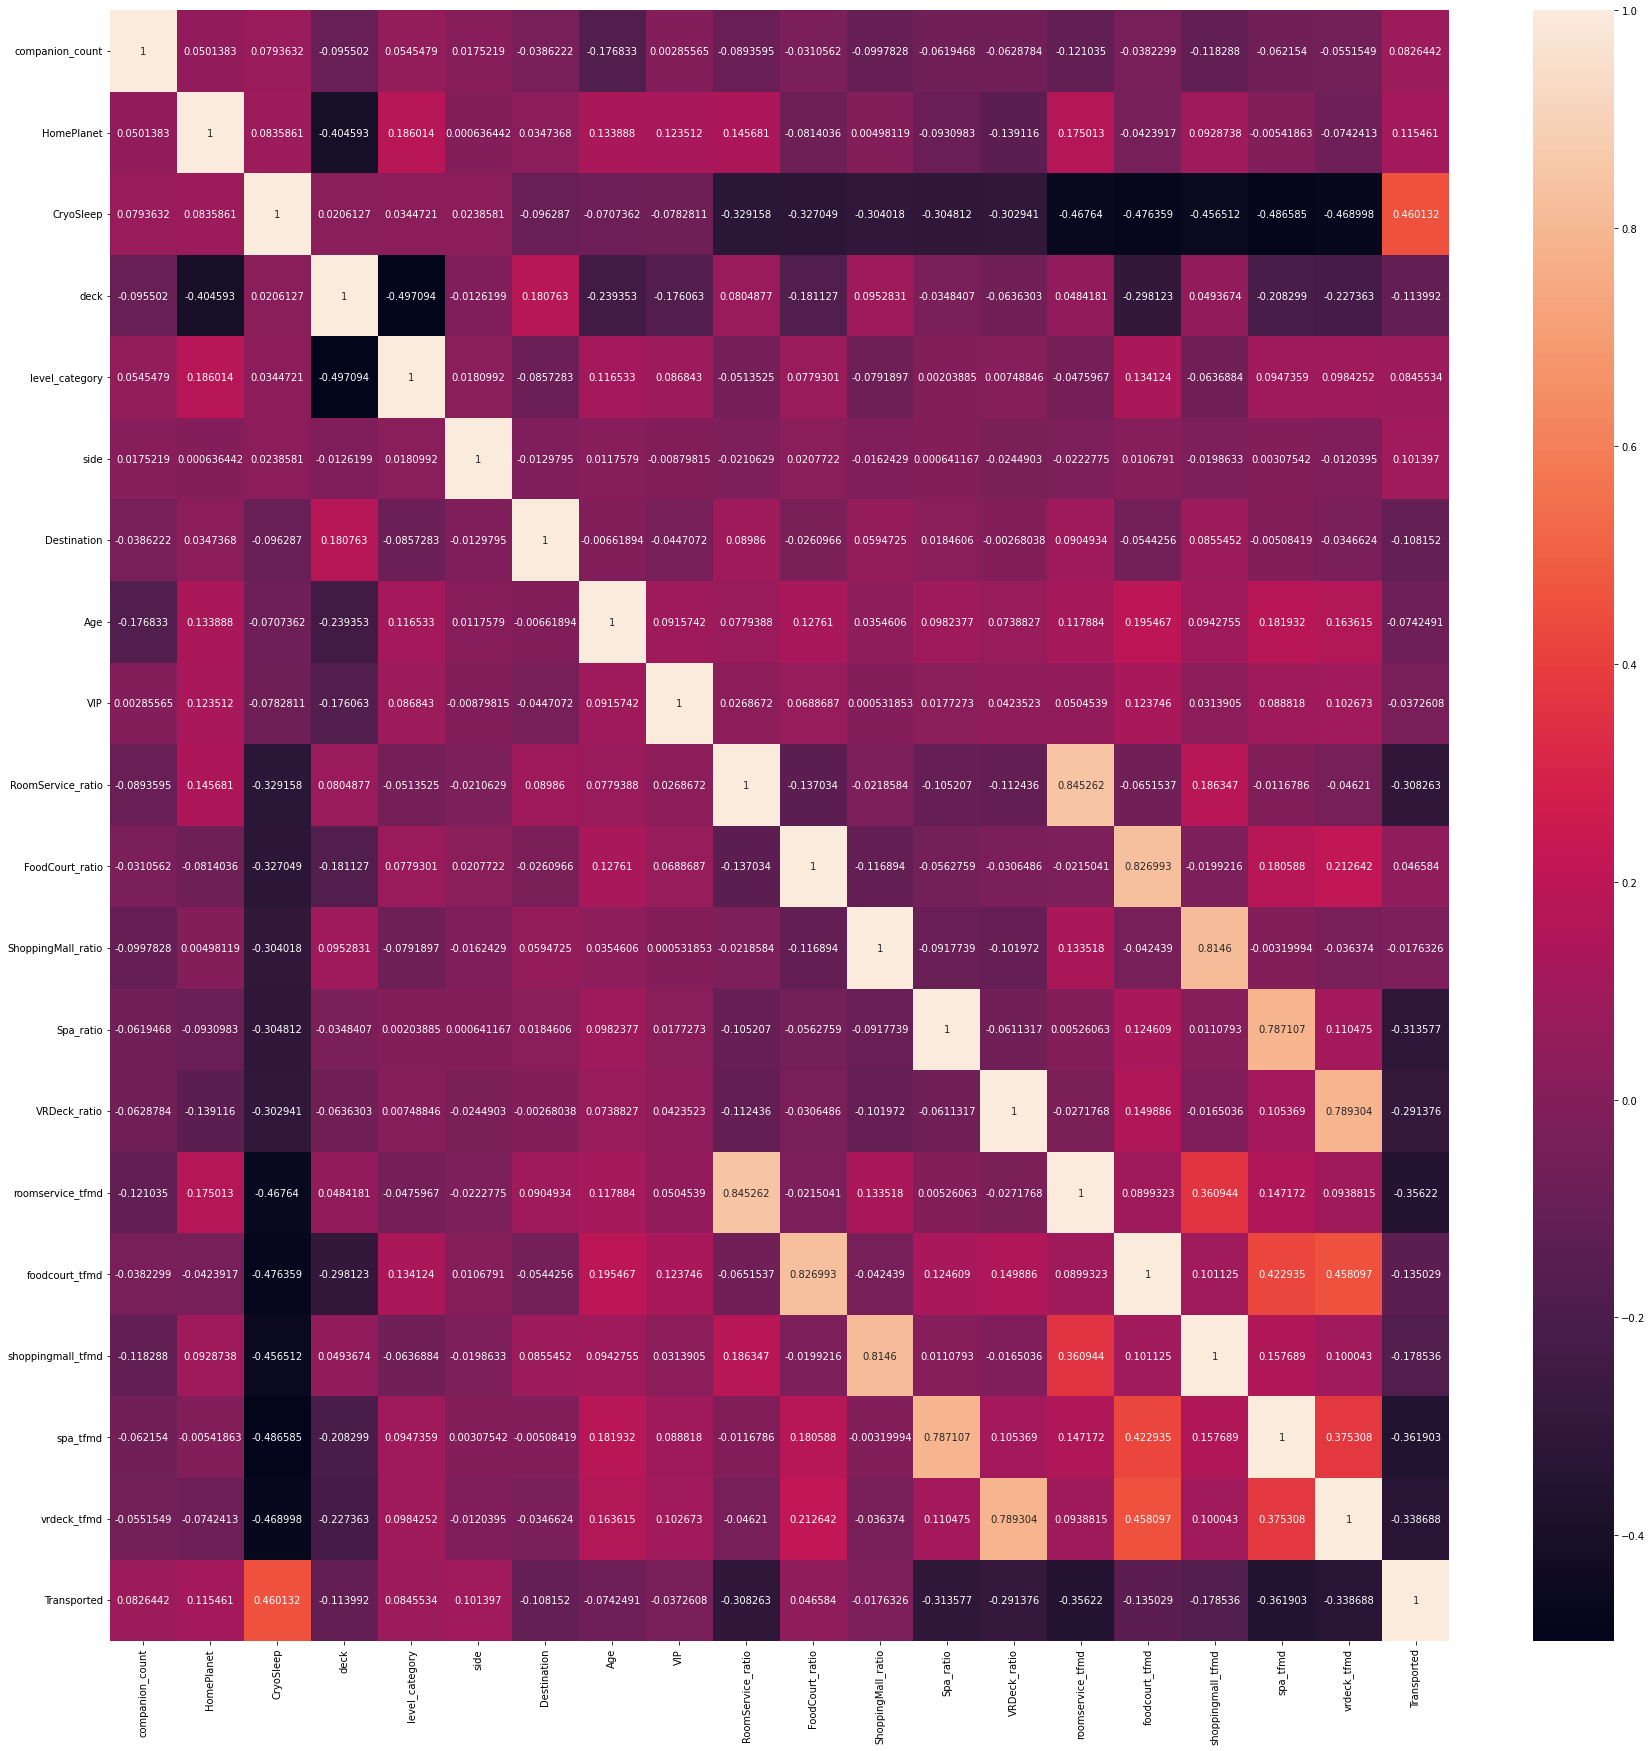

In [51]:
# Heatmap
plt.figure(figsize=(30,30))

sns.heatmap(train.corr(), annot = True, fmt = 'g')

plt.show()

Several of the predictor variables show little predictive value with respect to the target variable, Transported.
- companion_count, 0.083
- level_category, 0.085
- Age, -0.074
- VIP, -0.037

These should be excluded from the predictive model. However, based on earlier experiments, two model sets will be created. One will reflect the full model, and the other will reflect the reduced model.

In [52]:
# Create the full model
train_full = train.drop(['Transported'], axis=1)

# Check
train_full.head()

,companion_count,HomePlanet,CryoSleep,deck,level_category,side,Destination,Age,VIP,RoomService_ratio,FoodCourt_ratio,ShoppingMall_ratio,Spa_ratio,VRDeck_ratio,roomservice_tfmd,foodcourt_tfmd,shoppingmall_tfmd,spa_tfmd,vrdeck_tfmd
0,0,1,0,1,4,0,2,39.0,0,0.005607,0.011891,0.003574,0.011036,0.006766,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0,0,5,4,1,2,24.0,0,0.148098,0.012228,0.033967,0.745924,0.059783,4.700480,2.302585,3.258097,6.309918,3.806662
2,1,1,0,0,4,1,2,58.0,1,0.004141,0.344409,0.000000,0.646730,0.004719,3.784190,8.182280,0.000000,8.812248,3.912023
3,1,1,0,0,4,1,2,33.0,0,0.000000,0.247875,0.071677,0.643161,0.037287,0.000000,7.157735,5.918894,8.110728,5.267858
4,0,0,0,5,4,1,2,16.0,0,0.277727,0.064161,0.138405,0.517874,0.001833,5.717028,4.262680,5.023881,6.338594,1.098612


In [53]:
# Create the cleaned model
train_clean = train.drop(['companion_count', 'level_category', 'Age', 'VIP', 'Transported'], axis=1)

# Check
train_clean.head()

,HomePlanet,CryoSleep,deck,side,Destination,RoomService_ratio,FoodCourt_ratio,ShoppingMall_ratio,Spa_ratio,VRDeck_ratio,roomservice_tfmd,foodcourt_tfmd,shoppingmall_tfmd,spa_tfmd,vrdeck_tfmd
0,1,0,1,0,2,0.005607,0.011891,0.003574,0.011036,0.006766,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0,5,1,2,0.148098,0.012228,0.033967,0.745924,0.059783,4.700480,2.302585,3.258097,6.309918,3.806662
2,1,0,0,1,2,0.004141,0.344409,0.000000,0.646730,0.004719,3.784190,8.182280,0.000000,8.812248,3.912023
3,1,0,0,1,2,0.000000,0.247875,0.071677,0.643161,0.037287,0.000000,7.157735,5.918894,8.110728,5.267858
4,0,0,5,1,2,0.277727,0.064161,0.138405,0.517874,0.001833,5.717028,4.262680,5.023881,6.338594,1.098612


In [54]:
# Create cleaned test data
test_clean = test.drop(['companion_count', 'level_category', 'Age', 'VIP'], axis=1)

# Check
test_clean.head()

,HomePlanet,CryoSleep,deck,side,Destination,RoomService_ratio,FoodCourt_ratio,ShoppingMall_ratio,Spa_ratio,VRDeck_ratio,roomservice_tfmd,foodcourt_tfmd,shoppingmall_tfmd,spa_tfmd,vrdeck_tfmd
0,0,1,6,1,2,0.008226,0.010479,0.004582,0.010189,0.004405,0.000000,0.000000,0.000000,0.000000,0.00000
1,0,0,5,1,2,0.000000,0.003178,0.000000,0.996822,0.000000,0.000000,2.302585,0.000000,7.945910,0.00000
2,1,1,2,1,0,0.008226,0.010479,0.004582,0.010189,0.004405,0.000000,0.000000,0.000000,0.000000,0.00000
3,1,0,2,1,2,0.000000,0.896738,0.000000,0.024400,0.078862,0.000000,8.802823,0.000000,5.204007,6.37332
4,0,0,5,1,2,0.015504,0.000000,0.984496,0.000000,0.000000,2.397895,0.000000,6.455199,0.000000,0.00000


# Full Model: XGBoost + GridSearchCV + StratifiedKFold

In [55]:
# Split full model train set into train and validation sets
x_train1, x_validation1, y_train1, y_validation1 = train_test_split(train_full, y, test_size=0.1, shuffle=True, random_state=42)

In [56]:
# Evaluation set
full_eval_set=[(x_train1, y_train1), (x_validation1, y_validation1)]

In [ ]:
# XGBClassifier
xgbc=XGBClassifier(objective= 'binary:logistic',
                   nthread=6,
                   seed=42,
                   eval_metric = 'logloss')

In [ ]:
# Parameter dict for XGBC GridSearchCV object
full_params = {'max_depth': [5, 8, 10],
               'n_estimators': [200, 500, 1000],
               'eta': [0.05, 0.1, 0.03]}

In [ ]:
# Grid Search object
# Initialize the GridSearchCV object
gs = GridSearchCV(xgbc, param_grid=full_params, cv=StratifiedKFold(n_splits=10, shuffle=True).split(x_train1, y_train1), n_jobs=-1)

In [ ]:
# Fit the GridSearch object
gs.fit(x_train1, y_train1)

In [ ]:
# See the results
gs_results_pd = pd.DataFrame(gs.cv_results_)

# View
gs_results_pd

In [ ]:
# View the best parameters
gs.best_params_

In [ ]:
# New XGBClassifier based on best params
full_model = XGBClassifier(objective= 'binary:logistic',
                           eta=0.03,
                           max_depth=10,
                           #max_leaves=20,
                           subsample=0.8,
                           #colsample_bytree=0.8,
                           n_estimators=200,
                           nthread=6,
                           seed=42,
                           eval_metric =['error', 'logloss'])

In [ ]:
# Fit the model
full_model.fit(x_train1, y_train1, eval_set=full_eval_set)

In [ ]:
# Accuracy score
full_model_val_acc_score = accuracy_score(y_validation1, full_model.predict(x_validation1))
full_model_train_acc_score = accuracy_score(y_train1, full_model.predict(x_train1))

# View
print(f"Validation set accuracy score: {full_model_val_acc_score}.")
print(f"Training set accuracy score: {full_model_train_acc_score}.")

In [ ]:
# View confusion matrices - Validation and Prediction
fig, (ax0, ax1)=plt.subplots(1, 2, figsize=(20,14))

# Title
fig.suptitle('Confusion Matrices')
ax0.set_title('Validation')
ax1.set_title('Train')

ConfusionMatrixDisplay.from_predictions(y_validation1, full_model.predict(x_validation1), cmap='rocket', ax=ax0)
ConfusionMatrixDisplay.from_predictions(y_train1, full_model.predict(x_train1), cmap='rocket', ax=ax1)

In [ ]:
# Performance metrics
full_model_perf_results = full_model.evals_result()

In [ ]:
# Plot learning curves
plt.figure(figsize=(14,14))
plt.plot(full_model_perf_results['validation_0']['logloss'], label='train')
plt.plot(full_model_perf_results['validation_1']['logloss'], label='validation')

# Show where performance flattens out
#plt.axvline(x = 350, color='black')

# Labels
plt.suptitle('Log Loss for Training and Validation Sets')
plt.xlabel('n_estimators')
plt.ylabel('LogLoss')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# plot classification error
plt.figure(figsize=(14,14))
plt.plot(full_model_perf_results['validation_0']['error'], label='train')
plt.plot(full_model_perf_results['validation_1']['error'], label='validation')
plt.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

### Make Submission

In [ ]:
# Get the predictions
full_model_preds = full_model.predict(test)

In [ ]:
# Create a dataframe
data={'PassengerId': test_passenger_id, 'Transported': full_model_preds}

full_model_df=pd.DataFrame(data=data)

# Check
full_model_df.head()

In [ ]:
# Replacements
full_model_df.replace(to_replace=0, value='False', inplace=True)
full_model_df.replace(to_replace=1, value='True', inplace=True)

# Check
full_model_df.head()

In [ ]:
# Generate results
full_model_df.to_csv('full_model.csv', index=False)

# Clean Model: XGBoost + GridSearchCV + StratifiedKFold

In [56]:
# Split full model train set into train and validation sets
x_train2, x_validation2, y_train2, y_validation2 = train_test_split(train_clean, y, test_size=0.1, shuffle=True, random_state=42)

In [ ]:
# Evaluation set
clean_eval_set=[(x_train2, y_train2), (x_validation2, y_validation2)]

In [ ]:
# Grid Search object
# Initialize the GridSearchCV object
gs2 = GridSearchCV(xgbc, param_grid=full_params, cv=StratifiedKFold(n_splits=10, shuffle=True).split(x_train2, y_train2), n_jobs=-1)

In [ ]:
# Fit the new GridSearch object
gs2.fit(x_train2, y_train2)

In [ ]:
# See the params
gs2_results_pd = pd.DataFrame(gs2.cv_results_)

# View
gs2_results_pd

In [ ]:
# View the best parameters
gs2.best_params_

In [ ]:
# New XGBClassifier based on best params
clean_model = XGBClassifier(objective= 'binary:logistic',
                            eta=0.03,
                            max_depth=8,
                            #reg_lambda=0.2,
                            #colsample_bytree=0.8,
                            n_estimators=150,
                            nthread=6,
                            seed=42,
                            eval_metric =['error', 'logloss'])

In [ ]:
# Fit
clean_model.fit(x_train2, y_train2, eval_set=clean_eval_set)

In [ ]:
# Accuracy score
clean_model_val_acc_score = accuracy_score(y_validation2, clean_model.predict(x_validation2))
clean_model_train_acc_score = accuracy_score(y_train2, clean_model.predict(x_train2))

# View
print(f"Validation set accuracy score: {clean_model_val_acc_score}.")
print(f"Training set accuracy score: {clean_model_train_acc_score}.")

In [ ]:
# View confusion matrices - Validation and Prediction
fig, (ax0, ax1)=plt.subplots(1, 2, figsize=(20,14))

# Title
fig.suptitle('Confusion Matrices')
ax0.set_title('Validation')
ax1.set_title('Train')

ConfusionMatrixDisplay.from_predictions(y_validation2, clean_model.predict(x_validation2), cmap='rocket', ax=ax0)
ConfusionMatrixDisplay.from_predictions(y_train2, clean_model.predict(x_train2), cmap='rocket', ax=ax1)

In [ ]:
# Performance metrics
clean_model_perf_results = clean_model.evals_result()

In [ ]:
# Plot learning curves
plt.figure(figsize=(14,14))
plt.plot(clean_model_perf_results['validation_0']['logloss'], label='train')
plt.plot(clean_model_perf_results['validation_1']['logloss'], label='validation')

# Show where performance flattens out
#plt.axvline(x = 350, color='black')

# Labels
plt.suptitle('Log Loss for Training and Validation Sets')
plt.xlabel('n_estimators')
plt.ylabel('LogLoss')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# plot classification error
plt.figure(figsize=(14,14))
plt.plot(clean_model_perf_results['validation_0']['error'], label='train')
plt.plot(clean_model_perf_results['validation_1']['error'], label='validation')
plt.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

# Full Model: CatBoostClassifier + GridSearch + StratifiedKFold

In [57]:
# Import
from catboost import CatBoostClassifier, MetricVisualizer, MetricsPlotter

In [58]:
# Initialize CatBoostClassifier
cb = CatBoostClassifier(loss_function='Logloss', 
                        eval_metric='Accuracy',
                        random_seed=42)

In [6]:
# Parameters list
full_cat_params = {'iterations': [50, 100, 150],
                   'learning_rate': [0.03, 0.1, 0.05, 0.01],
                   'depth': [4, 6, 10],
                   'l2_leaf_reg': [1, 3, 5]}

In [61]:
# Grid search from in built model
fc_gs = cb.grid_search(full_cat_params, 
                          X=x_train1, 
                          y=y_train1, 
                          cv = StratifiedKFold(n_splits=10).split(x_train1, y_train1),
                          plot=True,
                          verbose=0)

IndentationError: unexpected indent (3906456534.py, line 3)

In [61]:
# Object importance
cb.get_params()

{'loss_function': 'Logloss',
 'random_seed': 42,
 'eval_metric': 'Accuracy',
 'depth': 6,
 'l2_leaf_reg': 3,
 'iterations': 150,
 'learning_rate': 0.03}

In [62]:
# Parameter output
cb_best_score = cb.best_score_

# View
print(f"Grid search best score: {cb_best_score}.")

Grid search best score: {'learn': {'Accuracy': 0.8129873450083088, 'Logloss': 0.40656428905042846}}.


In [59]:
# New CatBoostClassifier object
full_cb=CatBoostClassifier(iterations=150,
                           loss_function=['Error','Logloss'],
                           eval_metric='Accuracy',
                           random_seed=42,
                           depth=6,
                           l2_leaf_reg=3,
                           subsample=0.8,
                           learning_rate=0.03)

In [60]:
# Evaluation set
full_cat_eval = (x_validation1, y_validation1)

In [ ]:
# Fit
full_cb.fit(x_train1, y_train1)

AttributeError: 'list' object has no attribute '_jited'

Exception ignored in: '_catboost._BuildCustomObjectiveDescriptor'
Traceback (most recent call last):
  File "_catboost.pyx", line 1552, in _catboost._try_jit_methods
AttributeError: 'list' object has no attribute '_jited'


AttributeError: 'list' object has no attribute '_jited'